# Buliding the Graph

In [14]:
!pip install torch_geometric
import kagglehub
import re
import spacy
from sklearn.preprocessing import LabelEncoder
import numpy as np
import torch
from torch_geometric.data import Data
from transformers import AutoTokenizer, AutoModel
import random
import pandas as pd
import os
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch.nn.functional as F


# Set seeds for reproducibility
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

# Download Dataset
dataset_dir = kagglehub.dataset_download("crowdflower/political-social-media-posts")

# Find the CSV file within the directory
for filename in os.listdir(dataset_dir):
    if filename.endswith(".csv"):
        file_path = os.path.join(dataset_dir, filename)
        break
else:
    raise FileNotFoundError("No CSV file found in the dataset directory.")

# Read the CSV file, specifying encoding
data = pd.read_csv(file_path, encoding='latin-1')

# Drop missing values in key columns
data.dropna(subset=["text", "bias"], inplace=True)

# Load Spacy model for NLP processing
nlp = spacy.load("en_core_web_sm")

# Text Cleaning Function
def clean_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop and token.is_alpha])

data["text"] = data["text"].apply(clean_text)

# Entity Extraction Function
def extract_entities(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents] if doc.ents else []

data["entities"] = data["text"].apply(extract_entities)

# Encode bias labels
label_encoder = LabelEncoder()
data["bias_label_encoded"] = label_encoder.fit_transform(data["bias"])

# Save label encoder
import pickle
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

# Load pre-trained BERT model and tokenizer
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def get_bert_embeddings_batch(texts, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors='pt', truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
            batch_embeddings = outputs.last_hidden_state[:, 0, :]
        embeddings.extend(batch_embeddings.numpy())
    return embeddings

# Generate embeddings for articles
article_embeddings = get_bert_embeddings_batch(data["text"].tolist())

# Generate embeddings for unique entities
entity_texts = list(set(entity for entities in data["entities"] for entity in entities))
entity_embeddings = {entity: embedding for entity, embedding in zip(entity_texts, get_bert_embeddings_batch(entity_texts))}

# Build Graph
num_articles = len(data)
num_entities = len(entity_embeddings)

# Assign unique indices to entities
entity_index_map = {entity: i + num_articles for i, entity in enumerate(entity_embeddings)}

node_features = article_embeddings.copy()  # Article embeddings as node features
labels = data["bias_label_encoded"].tolist()
edge_index = []

# Add entity nodes and edges
for idx, row in data.iterrows():
    for entity in row["entities"]:
        if entity in entity_index_map:
            entity_idx = entity_index_map[entity]
            edge_index.append([idx, entity_idx])
            edge_index.append([entity_idx, idx])
            node_features.append(entity_embeddings[entity])

# Convert to tensors
node_features = torch.tensor(np.array(node_features), dtype=torch.float)
edge_index = torch.tensor(np.array(edge_index).T, dtype=torch.long)
labels = torch.tensor(labels, dtype=torch.long)

# Create PyTorch Geometric Data object
graph_data = Data(x=node_features, edge_index=edge_index, y=labels)

# Split Data into Train, Validation, and Test Sets
train_mask = torch.zeros(graph_data.num_nodes, dtype=torch.bool)
val_mask = torch.zeros(graph_data.num_nodes, dtype=torch.bool)
test_mask = torch.zeros(graph_data.num_nodes, dtype=torch.bool)

train_mask[:int(0.7 * num_articles)] = True
val_mask[int(0.7 * num_articles):int(0.85 * num_articles)] = True
test_mask[int(0.85 * num_articles):num_articles] = True

graph_data.train_mask = train_mask
graph_data.val_mask = val_mask
graph_data.test_mask = test_mask

print(graph_data)

torch.save(graph_data, "graph_data.pt")

Data(x=[16960, 768], edge_index=[2, 23920], y=[5000], train_mask=[16960], val_mask=[16960], test_mask=[16960])


In [12]:
print(f"Total Nodes: {graph_data.x.shape[0]}")
print(f"Max index in edge_index: {edge_index.max()}")
print(f"Edge index shape: {edge_index.shape}")


Total Nodes: 16960
Max index in edge_index: 10800
Edge index shape: torch.Size([2, 23920])


# GCNConv Model

In [16]:
from torch_geometric.nn import GCNConv


class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim)  # Batch Normalization
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(p=0.5)  # Dropout to prevent overfitting

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)  # Apply batch normalization
        x = F.relu(x)
        x = self.dropout(x)  # Apply dropout after activation
        x = self.conv2(x, edge_index)
        return x  # Return raw logits (CrossEntropyLoss applies log_softmax)

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GNN(
    input_dim=graph_data.x.shape[1],
    hidden_dim=64,
    output_dim=len(label_encoder.classes_)
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Weight decay for regularization
criterion = torch.nn.CrossEntropyLoss()

# Move data to device
graph_data = graph_data.to(device)

# Training Function
def train():
    model.train()
    optimizer.zero_grad()

    out = model(graph_data.x, graph_data.edge_index)  # Forward pass

    # Apply training mask only to article nodes
    article_train_mask = graph_data.train_mask[:num_articles]
    labels_train = graph_data.y[:num_articles][article_train_mask]
    preds_train = out[:num_articles][article_train_mask]

    loss = criterion(preds_train, labels_train)
    loss.backward()
    optimizer.step()

    return loss.item()

# Testing Function
def test():
    model.eval()
    with torch.no_grad():
        out = model(graph_data.x, graph_data.edge_index)
        pred = out.argmax(dim=1)  # Get predictions

        article_test_mask = graph_data.test_mask[:num_articles]
        pred_articles = pred[:num_articles][article_test_mask]
        true_labels = graph_data.y[:num_articles][article_test_mask]

        accuracy = accuracy_score(true_labels.cpu(), pred_articles.cpu())
        precision, recall, f1, _ = precision_recall_fscore_support(
            true_labels.cpu(), pred_articles.cpu(), average='weighted'
        )

        print("\n=== Test Results ===")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        return accuracy, precision, recall, f1

# Training Loop with Early Stopping
num_epochs = 200
best_f1 = 0.0

for epoch in range(num_epochs):
    loss = train()

    if (epoch + 1) % 10 == 0:  # Print every 10 epochs
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")

    # Evaluate model every 20 epochs
    if (epoch + 1) % 20 == 0:
        _, _, _, f1 = test()

        # Save best model based on F1 score
        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), "best_GCN_model.pth")
            print(f"Best model updated at epoch {epoch+1} with F1: {f1:.4f}")

# Final Test
test_accuracy, test_precision, test_recall, test_f1 = test()

# Save final model
torch.save(model.state_dict(), "GCN_model.pth")
print("\nFinal model saved as 'GCN_model.pth'")

Epoch 10/200, Loss: 0.6016
Epoch 20/200, Loss: 0.5530

=== Test Results ===
Accuracy: 0.8107
Precision: 0.7165
Recall: 0.8107
F1 Score: 0.7400
Best model updated at epoch 20 with F1: 0.7400
Epoch 30/200, Loss: 0.5304
Epoch 40/200, Loss: 0.5205

=== Test Results ===
Accuracy: 0.8347
Precision: 0.8083
Recall: 0.8347
F1 Score: 0.8042
Best model updated at epoch 40 with F1: 0.8042
Epoch 50/200, Loss: 0.5057
Epoch 60/200, Loss: 0.4894

=== Test Results ===
Accuracy: 0.8280
Precision: 0.7958
Recall: 0.8280
F1 Score: 0.7837
Epoch 70/200, Loss: 0.4910
Epoch 80/200, Loss: 0.4628

=== Test Results ===
Accuracy: 0.8453
Precision: 0.8275
Recall: 0.8453
F1 Score: 0.8146
Best model updated at epoch 80 with F1: 0.8146
Epoch 90/200, Loss: 0.4554
Epoch 100/200, Loss: 0.4447

=== Test Results ===
Accuracy: 0.8413
Precision: 0.8315
Recall: 0.8413
F1 Score: 0.7977
Epoch 110/200, Loss: 0.4366
Epoch 120/200, Loss: 0.4107

=== Test Results ===
Accuracy: 0.8320
Precision: 0.8288
Recall: 0.8320
F1 Score: 0.773

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 150/200, Loss: 0.4097
Epoch 160/200, Loss: 0.4136

=== Test Results ===
Accuracy: 0.8320
Precision: 0.8065
Recall: 0.8320
F1 Score: 0.7866
Epoch 170/200, Loss: 0.3801
Epoch 180/200, Loss: 0.3550

=== Test Results ===
Accuracy: 0.8413
Precision: 0.8258
Recall: 0.8413
F1 Score: 0.8019
Epoch 190/200, Loss: 0.3302
Epoch 200/200, Loss: 0.3293

=== Test Results ===
Accuracy: 0.8320
Precision: 0.8156
Recall: 0.8320
F1 Score: 0.7785

=== Test Results ===
Accuracy: 0.8320
Precision: 0.8156
Recall: 0.8320
F1 Score: 0.7785

Final model saved as 'GCN_model.pth'


# GraphSAGE Model

In [18]:
from torch_geometric.nn import SAGEConv

# Define GraphSAGE Model
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim, aggr='mean')  # 'mean' aggregation
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, output_dim, aggr='mean')
        self.dropout = torch.nn.Dropout(p=0.5)  # Dropout to prevent overfitting

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)  # Apply dropout after activation
        x = self.conv2(x, edge_index)
        return x  # Return raw logits (CrossEntropyLoss applies log_softmax)


# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GNN(
    input_dim=graph_data.x.shape[1],
    hidden_dim=64,
    output_dim=len(label_encoder.classes_)
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Weight decay for regularization
criterion = torch.nn.CrossEntropyLoss()

# Move data to device
graph_data = graph_data.to(device)

# Training Function
def train():
    model.train()
    optimizer.zero_grad()

    out = model(graph_data.x, graph_data.edge_index)  # Forward pass

    # Apply training mask only to article nodes
    article_train_mask = graph_data.train_mask[:num_articles]
    labels_train = graph_data.y[:num_articles][article_train_mask]
    preds_train = out[:num_articles][article_train_mask]

    loss = criterion(preds_train, labels_train)
    loss.backward()
    optimizer.step()

    return loss.item()

# Testing Function
def test():
    model.eval()
    with torch.no_grad():
        out = model(graph_data.x, graph_data.edge_index)
        pred = out.argmax(dim=1)  # Get predictions

        article_test_mask = graph_data.test_mask[:num_articles]
        pred_articles = pred[:num_articles][article_test_mask]
        true_labels = graph_data.y[:num_articles][article_test_mask]

        accuracy = accuracy_score(true_labels.cpu(), pred_articles.cpu())
        precision, recall, f1, _ = precision_recall_fscore_support(
            true_labels.cpu(), pred_articles.cpu(), average='weighted'
        )

        print("\n=== Test Results ===")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        return accuracy, precision, recall, f1

# Training Loop with Early Stopping
num_epochs = 200
best_f1 = 0.0

for epoch in range(num_epochs):
    loss = train()

    if (epoch + 1) % 10 == 0:  # Print every 10 epochs
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")

    # Evaluate model every 20 epochs
    if (epoch + 1) % 20 == 0:
        _, _, _, f1 = test()

        # Save best model based on F1 score
        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), "best_GraphSAGE_model.pth")
            print(f"Best model updated at epoch {epoch+1} with F1: {f1:.4f}")

# Final Test
test_accuracy, test_precision, test_recall, test_f1 = test()

# Save final model
torch.save(model.state_dict(), "GraphSAGE_model.pth")
print("\nFinal model saved as 'GraphSAGE_model.pth'")


Epoch 10/200, Loss: 0.5523
Epoch 20/200, Loss: 0.5195

=== Test Results ===
Accuracy: 0.8440
Precision: 0.8247
Recall: 0.8440
F1 Score: 0.8260
Best model updated at epoch 20 with F1: 0.8260
Epoch 30/200, Loss: 0.5059
Epoch 40/200, Loss: 0.4948

=== Test Results ===
Accuracy: 0.8253
Precision: 0.8341
Recall: 0.8253
F1 Score: 0.8292
Best model updated at epoch 40 with F1: 0.8292
Epoch 50/200, Loss: 0.4757
Epoch 60/200, Loss: 0.4520

=== Test Results ===
Accuracy: 0.8093
Precision: 0.8403
Recall: 0.8093
F1 Score: 0.8206
Epoch 70/200, Loss: 0.4296
Epoch 80/200, Loss: 0.4049

=== Test Results ===
Accuracy: 0.8427
Precision: 0.8274
Recall: 0.8427
F1 Score: 0.8316
Best model updated at epoch 80 with F1: 0.8316
Epoch 90/200, Loss: 0.3721
Epoch 100/200, Loss: 0.3703

=== Test Results ===
Accuracy: 0.8227
Precision: 0.7826
Recall: 0.8227
F1 Score: 0.7739
Epoch 110/200, Loss: 0.3406
Epoch 120/200, Loss: 0.3229

=== Test Results ===
Accuracy: 0.7973
Precision: 0.8237
Recall: 0.7973
F1 Score: 0.807

# GAT Model

In [20]:
from torch_geometric.nn import GATConv

# Define GAT Model
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        # First GAT layer with multiple attention heads
        self.conv1 = GATConv(
            in_channels=input_dim,
            out_channels=hidden_dim,
            heads=8,  # 8 attention heads
            dropout=0.5
        )
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim * 8)  # BatchNorm for concatenated heads

        # Second GAT layer (output layer)
        self.conv2 = GATConv(
            in_channels=hidden_dim * 8,
            out_channels=output_dim,
            heads=1,  # Single attention head for output
            concat=False,  # Don't concatenate in output layer
            dropout=0.5
        )
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)  # Apply batch normalization
        x = F.elu(x)  # Use ELU activation as recommended in GAT paper
        x = self.dropout(x)  # Dropout after activation

        x = self.conv2(x, edge_index)  # Output layer
        return x  # Return raw logits (CrossEntropyLoss applies log_softmax)


# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GNN(
    input_dim=graph_data.x.shape[1],
    hidden_dim=64,
    output_dim=len(label_encoder.classes_)
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Weight decay for regularization
criterion = torch.nn.CrossEntropyLoss()

# Move data to device
graph_data = graph_data.to(device)

# Training Function
def train():
    model.train()
    optimizer.zero_grad()

    out = model(graph_data.x, graph_data.edge_index)  # Forward pass

    # Apply training mask only to article nodes
    article_train_mask = graph_data.train_mask[:num_articles]
    labels_train = graph_data.y[:num_articles][article_train_mask]
    preds_train = out[:num_articles][article_train_mask]

    loss = criterion(preds_train, labels_train)
    loss.backward()
    optimizer.step()

    return loss.item()

# Testing Function
def test():
    model.eval()
    with torch.no_grad():
        out = model(graph_data.x, graph_data.edge_index)
        pred = out.argmax(dim=1)  # Get predictions

        article_test_mask = graph_data.test_mask[:num_articles]
        pred_articles = pred[:num_articles][article_test_mask]
        true_labels = graph_data.y[:num_articles][article_test_mask]

        accuracy = accuracy_score(true_labels.cpu(), pred_articles.cpu())
        precision, recall, f1, _ = precision_recall_fscore_support(
            true_labels.cpu(), pred_articles.cpu(), average='weighted'
        )

        print("\n=== Test Results ===")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        return accuracy, precision, recall, f1

# Training Loop with Early Stopping
num_epochs = 200
best_f1 = 0.0

for epoch in range(num_epochs):
    loss = train()

    if (epoch + 1) % 10 == 0:  # Print every 10 epochs
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")

    # Evaluate model every 20 epochs
    if (epoch + 1) % 20 == 0:
        _, _, _, f1 = test()

        # Save best model based on F1 score
        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), "best_GAT_model.pth")
            print(f"Best model updated at epoch {epoch+1} with F1: {f1:.4f}")

# Final Test
test_accuracy, test_precision, test_recall, test_f1 = test()

# Save final model
torch.save(model.state_dict(), "GAT_model.pth")
print("\nFinal model saved as 'GAT_model.pth'")


Epoch 10/200, Loss: 0.6965
Epoch 20/200, Loss: 0.6128

=== Test Results ===
Accuracy: 0.7440
Precision: 0.8427
Recall: 0.7440
F1 Score: 0.7707
Best model updated at epoch 20 with F1: 0.7707
Epoch 30/200, Loss: 0.5767
Epoch 40/200, Loss: 0.5597

=== Test Results ===
Accuracy: 0.8227
Precision: 0.8078
Recall: 0.8227
F1 Score: 0.8134
Best model updated at epoch 40 with F1: 0.8134
Epoch 50/200, Loss: 0.5439
Epoch 60/200, Loss: 0.5411

=== Test Results ===
Accuracy: 0.7787
Precision: 0.8452
Recall: 0.7787
F1 Score: 0.7986
Epoch 70/200, Loss: 0.5482
Epoch 80/200, Loss: 0.5291

=== Test Results ===
Accuracy: 0.8227
Precision: 0.7881
Recall: 0.8227
F1 Score: 0.7575
Epoch 90/200, Loss: 0.5358
Epoch 100/200, Loss: 0.5375

=== Test Results ===
Accuracy: 0.8307
Precision: 0.8468
Recall: 0.8307
F1 Score: 0.8371
Best model updated at epoch 100 with F1: 0.8371
Epoch 110/200, Loss: 0.5355
Epoch 120/200, Loss: 0.5278

=== Test Results ===
Accuracy: 0.8347
Precision: 0.8103
Recall: 0.8347
F1 Score: 0.79

# Gated-GNN Model

In [31]:
from torch_geometric.nn import GatedGraphConv

# Define Gated-GNN Model
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()

        if hidden_dim < input_dim:
            raise ValueError("hidden_dim must be >= input_dim")

        # GatedGraphConv layer with GRU updates
        self.conv1 = GatedGraphConv(
            out_channels=hidden_dim,  # Hidden dimension must be >= input_dim
            num_layers=3,  # Message passing iterations
            aggr='add'  # Aggregation method
        )

        self.lin = torch.nn.Linear(hidden_dim, output_dim)  # Final linear layer
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)  # Gated message passing
        x = F.relu(x)
        x = self.dropout(x)
        x = self.lin(x)  # Output layer
        return x  # Raw logits



# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Model Initialization
model = GNN(
    input_dim=graph_data.x.shape[1],  # Input dimension (e.g., 32)
    hidden_dim=max(64, graph_data.x.shape[1]),  # Ensure hidden_dim >= input_dim
    output_dim=len(label_encoder.classes_)  # Output dimension (number of classes)
).to(device)



optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Weight decay for regularization
criterion = torch.nn.CrossEntropyLoss()

# Move data to device
graph_data = graph_data.to(device)

# Training Function
def train():
    model.train()
    optimizer.zero_grad()

    out = model(graph_data.x, graph_data.edge_index)  # Forward pass

    # Apply training mask only to article nodes
    article_train_mask = graph_data.train_mask[:num_articles]
    labels_train = graph_data.y[:num_articles][article_train_mask]
    preds_train = out[:num_articles][article_train_mask]

    loss = criterion(preds_train, labels_train)
    loss.backward()
    optimizer.step()

    return loss.item()

# Testing Function
def test():
    model.eval()
    with torch.no_grad():
        out = model(graph_data.x, graph_data.edge_index)
        pred = out.argmax(dim=1)  # Get predictions

        article_test_mask = graph_data.test_mask[:num_articles]
        pred_articles = pred[:num_articles][article_test_mask]
        true_labels = graph_data.y[:num_articles][article_test_mask]

        accuracy = accuracy_score(true_labels.cpu(), pred_articles.cpu())
        precision, recall, f1, _ = precision_recall_fscore_support(
            true_labels.cpu(), pred_articles.cpu(), average='weighted'
        )

        print("\n=== Test Results ===")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        return accuracy, precision, recall, f1

# Training Loop with Early Stopping
num_epochs = 200
best_f1 = 0.0

for epoch in range(num_epochs):
    loss = train()

    if (epoch + 1) % 10 == 0:  # Print every 10 epochs
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")

    # Evaluate model every 20 epochs
    if (epoch + 1) % 20 == 0:
        _, _, _, f1 = test()

        # Save best model based on F1 score
        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), "best_Gated-GNN_model.pth")
            print(f"Best model updated at epoch {epoch+1} with F1: {f1:.4f}")

# Final Test
test_accuracy, test_precision, test_recall, test_f1 = test()

# Save final model
torch.save(model.state_dict(), "Gated-GNN_model.pth")
print("\nFinal model saved as 'Gated-GNN_model.pth'")

Epoch 10/200, Loss: 0.6715
Epoch 20/200, Loss: 0.6221

=== Test Results ===
Accuracy: 0.8120
Precision: 0.7109
Recall: 0.8120
F1 Score: 0.7385
Best model updated at epoch 20 with F1: 0.7385
Epoch 30/200, Loss: 0.5985
Epoch 40/200, Loss: 0.5719

=== Test Results ===
Accuracy: 0.8107
Precision: 0.7237
Recall: 0.8107
F1 Score: 0.7422
Best model updated at epoch 40 with F1: 0.7422
Epoch 50/200, Loss: 0.5433
Epoch 60/200, Loss: 0.5497

=== Test Results ===
Accuracy: 0.8293
Precision: 0.8004
Recall: 0.8293
F1 Score: 0.8012
Best model updated at epoch 60 with F1: 0.8012
Epoch 70/200, Loss: 0.5281
Epoch 80/200, Loss: 0.5178

=== Test Results ===
Accuracy: 0.8320
Precision: 0.8255
Recall: 0.8320
F1 Score: 0.8284
Best model updated at epoch 80 with F1: 0.8284
Epoch 90/200, Loss: 0.5402
Epoch 100/200, Loss: 0.5438

=== Test Results ===
Accuracy: 0.7387
Precision: 0.8251
Recall: 0.7387
F1 Score: 0.7645
Epoch 110/200, Loss: 0.5448
Epoch 120/200, Loss: 0.5242

=== Test Results ===
Accuracy: 0.8187
P

# GIN Model

In [26]:
from torch_geometric.nn import GATConv

# Define GAT Model
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()

        # First GAT layer with 8 attention heads
        self.conv1 = GATConv(
            in_channels=input_dim,
            out_channels=hidden_dim,
            heads=8,
            dropout=0.6
        )

        # Second GAT layer (final layer)
        self.conv2 = GATConv(
            in_channels=hidden_dim * 8,  # Output of conv1 is hidden_dim * heads
            out_channels=output_dim,
            heads=1,
            concat=False,  # Concatenation is False for final layer
            dropout=0.6
        )

        self.dropout = torch.nn.Dropout(p=0.5)  # Dropout for regularization

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)  # First GAT layer
        x = F.elu(x)                # ELU activation
        x = self.dropout(x)        # Dropout after activation
        x = self.conv2(x, edge_index)  # Second GAT layer
        return x  # Output raw logits (CrossEntropyLoss handles log_softmax)

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GNN(
    input_dim=graph_data.x.shape[1],
    hidden_dim=64,  # Ensure this is large enough
    output_dim=len(label_encoder.classes_)
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()  # Use class weights if imbalanced

graph_data = graph_data.to(device)  # Move data to GPU/CPU

# Training function
def train():
    model.train()
    optimizer.zero_grad()

    out = model(graph_data.x, graph_data.edge_index)  # Forward pass

    # Apply training mask to article nodes
    article_train_mask = graph_data.train_mask[:num_articles]
    labels_train = graph_data.y[:num_articles][article_train_mask]
    preds_train = out[:num_articles][article_train_mask]

    loss = criterion(preds_train, labels_train)
    loss.backward()
    optimizer.step()

    return loss.item()

# Training loop
num_epochs = 300  # Increased epochs for better learning
best_f1 = 0.0

for epoch in range(num_epochs):
    loss = train()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")

    # Validate and save best model every 20 epochs
    if (epoch + 1) % 20 == 0:
        _, _, _, f1 = test()
        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), "best_GAT_model.pth")
            print(f"Best GAT model saved with F1: {f1:.4f}")

# Save the final model
torch.save(model.state_dict(), "GAT_model.pth")
print("Final GAT model saved as 'GAT_model.pth'")


Epoch 10/300, Loss: 0.8719
Epoch 20/300, Loss: 0.7187

=== Test Results ===
Accuracy: 0.8187
Precision: 0.7616
Recall: 0.8187
F1 Score: 0.7395
Best GAT model saved with F1: 0.7395
Epoch 30/300, Loss: 0.6648
Epoch 40/300, Loss: 0.6040

=== Test Results ===
Accuracy: 0.8347
Precision: 0.8202
Recall: 0.8347
F1 Score: 0.8251
Best GAT model saved with F1: 0.8251
Epoch 50/300, Loss: 0.5989
Epoch 60/300, Loss: 0.5730

=== Test Results ===
Accuracy: 0.8387
Precision: 0.8167
Recall: 0.8387
F1 Score: 0.8183
Epoch 70/300, Loss: 0.5770
Epoch 80/300, Loss: 0.5722

=== Test Results ===
Accuracy: 0.8387
Precision: 0.8160
Recall: 0.8387
F1 Score: 0.8165
Epoch 90/300, Loss: 0.5648
Epoch 100/300, Loss: 0.5543

=== Test Results ===
Accuracy: 0.8280
Precision: 0.7992
Recall: 0.8280
F1 Score: 0.7758
Epoch 110/300, Loss: 0.5527
Epoch 120/300, Loss: 0.5569

=== Test Results ===
Accuracy: 0.8320
Precision: 0.8057
Recall: 0.8320
F1 Score: 0.7880
Epoch 130/300, Loss: 0.5466
Epoch 140/300, Loss: 0.5465

=== Test

# Graph Visualization

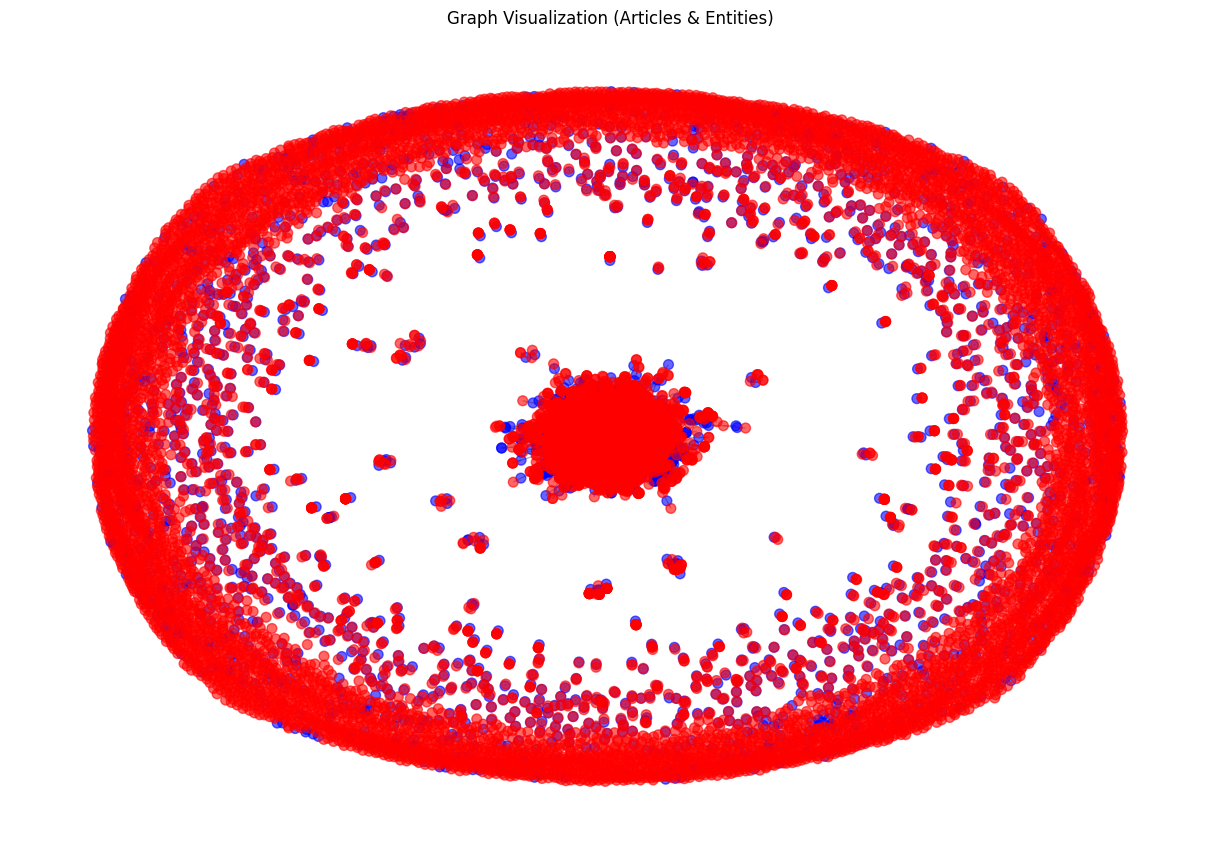

In [13]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Convert PyG graph to NetworkX format
G = to_networkx(graph_data, to_undirected=True)

# Assign colors: Articles (Blue), Entities (Red)
node_colors = ["blue" if i < len(data) else "red" for i in range(graph_data.num_nodes)]

# Set figure size
plt.figure(figsize=(12, 8))

# Draw the graph with node colors
pos = nx.spring_layout(G, seed=42)  # Spring layout for better visualization
nx.draw(G, pos, node_color=node_colors, with_labels=False, node_size=50, edge_color="gray", alpha=0.6)

# Show the graph
plt.title("Graph Visualization (Articles & Entities)")
plt.show()


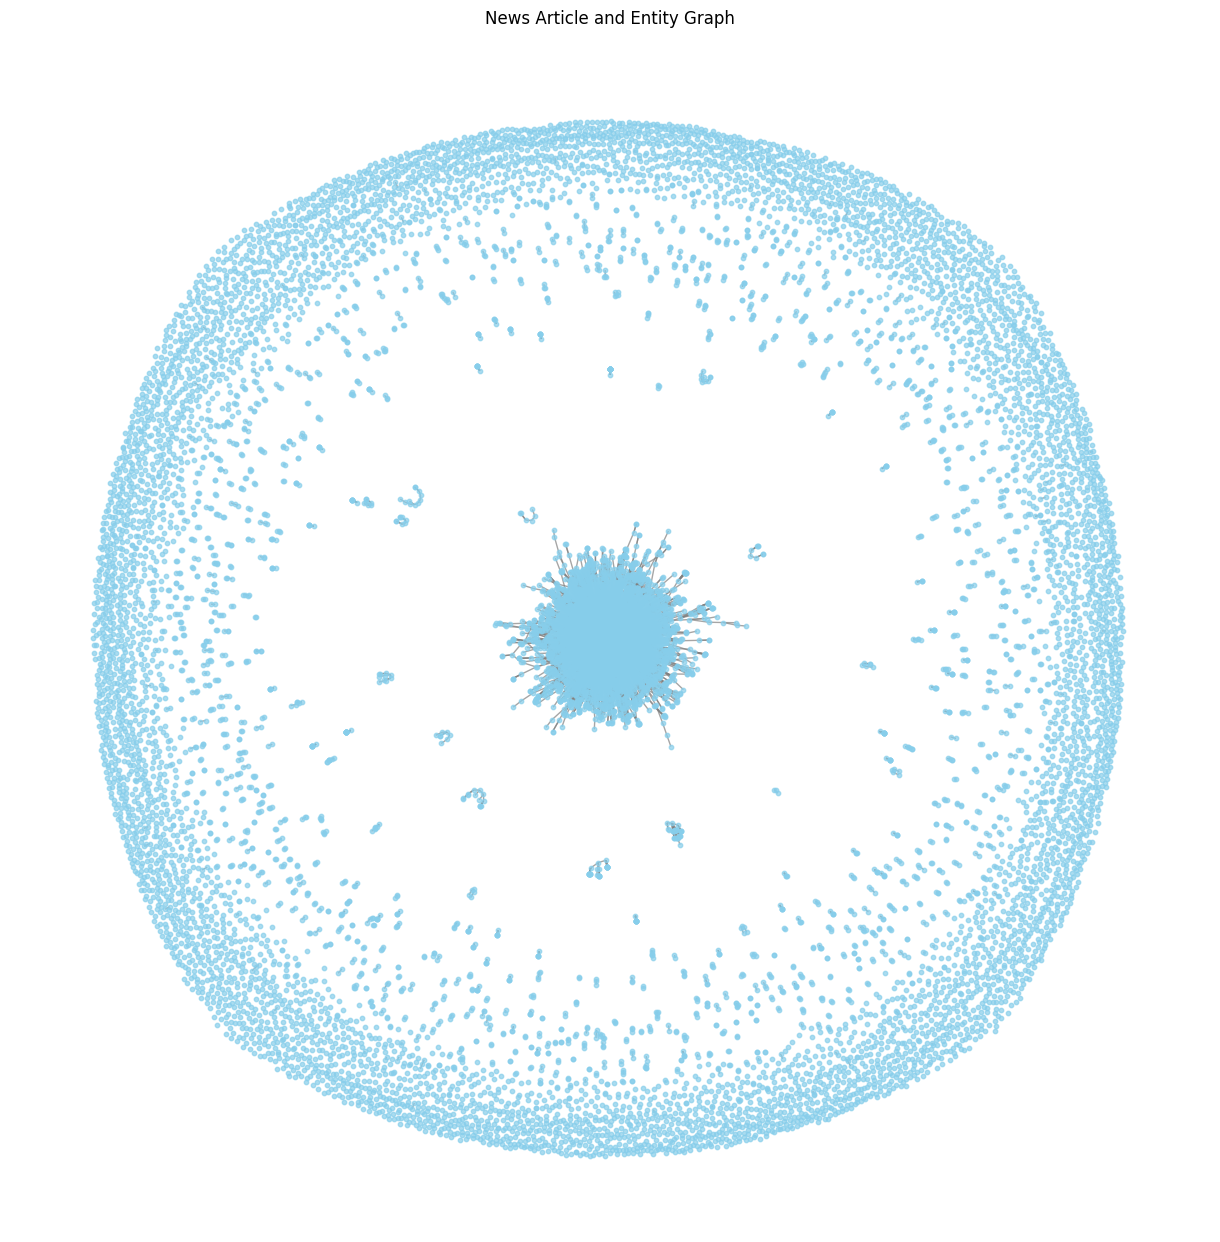

In [32]:
# prompt: Visualize the Graph:


# Assuming 'graph_data' is your PyTorch Geometric Data object
# Extract the necessary information
edge_index = graph_data.edge_index.numpy()
num_nodes = graph_data.num_nodes

# Create a NetworkX graph
G = nx.Graph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from(edge_index.T)

# Visualize the graph
plt.figure(figsize=(12, 12))  # Adjust figure size for better visualization
pos = nx.spring_layout(G, seed=42)  # Use a layout algorithm (e.g., spring_layout)
nx.draw(G, pos, with_labels=False, node_size=10, node_color="skyblue", edge_color="gray", alpha=0.7)
plt.title("News Article and Entity Graph")
plt.show()


# Statistics

In [27]:
# Number of Nodes & Edges
num_nodes = graph_data.num_nodes
num_edges = graph_data.num_edges

# Number of Unique Labels (Bias Categories)
num_labels = len(torch.unique(graph_data.y))

# Print Statistics
print(f"📌 Number of Nodes: {num_nodes}")
print(f"📌 Number of Edges: {num_edges}")
print(f"📌 Number of Unique Labels: {num_labels}")


📌 Number of Nodes: 16960
📌 Number of Edges: 23920
📌 Number of Unique Labels: 2
